In [1]:
import datetime as dt
import math

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

import sys

sys.path.append("..")
# from tooling.enums import AssetClass, Index, Spot, StrikeSpread
# from tooling.fetch import fetch_option_data, fetch_spot_data
# from tooling.filter import find_atm, option_tool

from fetching_from_local_db.enums import AssetClass, Index, StrikeSpread
from fetching_from_local_db.fetch_from_db import (
    _fetch_batch,
    fetch_data,
    fetch_spot_data,
)

In [2]:
async def get_expiry(f_today):

    if (f_today <= dt.date(2024, 1, 25)) and (f_today >= dt.date(2024, 1, 18)):
        f_expiry = dt.date(2024, 1, 25)
    elif (f_today <= dt.date(2024, 1, 31)) and (f_today >= dt.date(2024, 1, 26)):
        f_expiry = dt.date(2024, 1, 31)
    elif (f_today <= dt.date(2024, 2, 22)) and (f_today >= dt.date(2024, 2, 29)):
        f_expiry = dt.date(2024, 2, 29)
    elif (f_today <= dt.date(2024, 3, 25)) and (f_today >= dt.date(2024, 3, 27)):
        f_expiry = dt.date(2024, 2, 27)
    elif f_today < dt.date(2023, 9, 1):
        days_to_thursday = (3 - f_today.weekday()) % 7
        nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
        f_expiry = nearest_thursday
        if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
            f_expiry = nearest_thursday - dt.timedelta(days=1)
    elif f_today >= dt.date(2023, 9, 1):
        if f_today.day < 24:
            days_to_wednesday = (2 - f_today.weekday()) % 7
            nearest_wednesday = f_today + dt.timedelta(days=days_to_wednesday)
            f_expiry = nearest_wednesday
            if nse.valid_days(
                start_date=nearest_wednesday, end_date=nearest_wednesday
            ).empty:
                f_expiry = nearest_wednesday - dt.timedelta(days=1)
        else:
            days_to_thursday = (3 - f_today.weekday()) % 7
            nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
            f_expiry = nearest_thursday
            if nse.valid_days(
                start_date=nearest_thursday, end_date=nearest_thursday
            ).empty:
                f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_finnifty(f_today):

    days_to_thursday = (1 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_nifty(f_today):

    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_midcpnifty(f_today):

    days_to_thursday = (0 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


import datetime as dt


async def get_monthly_expiry_nifty(input_date):
    # Get the last day of the current month
    current_month_last_day = (
        input_date.replace(day=28) + dt.timedelta(days=4)
    ).replace(day=1) - dt.timedelta(days=1)

    # Find the last Thursday of the current month
    last_thursday_current_month = current_month_last_day - dt.timedelta(
        days=(current_month_last_day.weekday() - 3) % 7
    )

    # Check if the current date is less than the last Thursday of the current month
    if input_date < last_thursday_current_month:
        last_thursday = last_thursday_current_month
    else:
        # If the current date has passed the last Thursday, find the last Thursday of the next month
        next_month = (input_date.month % 12) + 1
        next_month_year = input_date.year if next_month > 1 else input_date.year + 1

        # Get the last day of the next month (considering February correctly)
        if next_month == 2:  # February
            if next_month_year % 4 == 0 and (
                next_month_year % 100 != 0 or next_month_year % 400 == 0
            ):
                last_day_of_next_month = 29  # Leap year
            else:
                last_day_of_next_month = 28  # Non-leap year
        else:
            # Calculate the last day of the next month
            last_day_of_next_month = (
                dt.date(next_month_year, next_month, 1) + dt.timedelta(days=31)
            ).replace(day=1) - dt.timedelta(days=1)
            last_day_of_next_month = (
                last_day_of_next_month.day
            )  # Extract the day as an integer

        # Create a date for the last day of the next month
        last_day_of_next_month_date = dt.date(
            next_month_year, next_month, last_day_of_next_month
        )

        # Find the last Thursday of the next month
        last_thursday = last_day_of_next_month_date - dt.timedelta(
            days=(last_day_of_next_month_date.weekday() - 3) % 7
        )

    # Validate if the last Thursday is a trading day
    if nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
        # If it's a holiday, find the previous valid trading day
        last_thursday -= dt.timedelta(days=1)
        while nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
            last_thursday -= dt.timedelta(days=1)

    return last_thursday


async def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [3]:
# bnf_pandas = pd.read_csv("../data/bnf_min.csv")
bnf_pandas = pd.read_csv("../data/nifty.csv")
# bnf_pandas = pd.read_csv("../data/fin_min.csv")
# bnf_pandas = pd.read_csv("../data/midcp_min.csv")
# bnf_pandas = pd.read_csv("../data/sensex_min.csv")
# bnf_pandas = pd.read_csv("../data/bankex_min.csv")

In [4]:
# If Stocks Data ...
bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["datetime"])
bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# bnf_pandas

In [5]:
bnf = pl.DataFrame(bnf_pandas)
print(type(bnf))
# bnf

<class 'polars.dataframe.frame.DataFrame'>


In [6]:
bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")
bnf = bnf.with_columns(pl.col("index").alias("datetime"))

In [7]:
# bnf = bnf.rename({"open": "o", "high": "h", "low": "l", "close": "c", "volume": "v"})

In [8]:
def resample(data, timeframe, offset=None):
    agg_list = [
        pl.col("o").first().alias("o"),
        pl.col("h").max().alias("h"),
        pl.col("l").min().alias("l"),
        pl.col("c").last().alias("c"),
    ]
    if "v" in data.columns:
        agg_list.append(pl.col("v").sum().alias("v"))
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(agg_list)
    )


In [9]:
import pandas as pd

def calculate_tradingview_rsi(df, rsi_period=14, column_name="c"):
    """
    Calculate RSI matching TradingView's methodology using RMA (Relative Moving Average).

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - column_name (str): Column name to calculate RSI on (default is 'close').
    - rsi_period (int): Period for the RSI calculation (default is 14).

    Returns:
    - pd.DataFrame: Original DataFrame with an added 'RSI' column matching TradingView's RSI.
    """
    if column_name not in df.columns:
        raise ValueError(f"The column '{column_name}' is not in the DataFrame.")
    
    # Ensure the input column is numeric
    if not pd.api.types.is_numeric_dtype(df[column_name]):
        raise TypeError(f"The column '{column_name}' must be numeric.")
    
    # Calculate price changes
    delta = df[column_name].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate RMA for gain and loss
    rma_gain = gain.ewm(alpha=1 / rsi_period, adjust=False).mean()
    rma_loss = loss.ewm(alpha=1 / rsi_period, adjust=False).mean()

    # Compute RSI
    rs = rma_gain / rma_loss
    df["RSI"] = 100 - (100 / (1 + rs))
    
    return df['RSI']


In [10]:
def generate_signals(df, n=5, rsi_n=14, rsi_overbought=66):
    import numpy as np
    import pandas as pd

    # Ensure required columns are present
    required_cols = {'o', 'h', 'l', 'c', 'datetime'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    # Ensure datetime is in datetime format
    if not np.issubdtype(df['datetime'].dtype, np.datetime64):
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Calculate the low of the previous n candles
    df['Prev_N_Low'] = df['l'].rolling(window=n).min().shift(1)
    df['daily_high_till_now'] = df.groupby(df['datetime'].dt.date)['h'].cummax()

    df['RSI'] = calculate_tradingview_rsi(df, rsi_n)

    # Generate sell signal
    df['Sell Signal'] = (df['RSI'] > rsi_overbought) & (df['c'] < df['Prev_N_Low'])

    # Drop intermediate columns if not needed
    df.drop(columns=['Prev_N_Low'], inplace=True, errors='ignore')
    
    return df


In [11]:
data = bnf_pandas.copy()
# data['datetime'] = pd.to_datetime(data['datetime'].dt.date)
print(data["datetime"].tail())
trading_days_set = set(data["datetime"].dt.date)
# sorted(trading_days_set)

735722   2024-12-13 15:25:00
735723   2024-12-13 15:26:00
735724   2024-12-13 15:27:00
735725   2024-12-13 15:28:00
735726   2024-12-13 15:29:00
Name: datetime, dtype: datetime64[ns]


In [12]:
# GLOBAL VARIABLES

INSTRUMENT = "NIFTY"
INDEX = "nifty"
INDEX_MROUND = 50
# INDEX_MROUND=100

# INSTRUMENT = "NIFTY"
# INDEX = "nifty"
# INDEX_MROUND=50

PORTFOLIO_VALUE = 10_00_000
INDEX_LEV = 6
RPT_CE = 0.02
RPT_PE = 0.02
SLIPPAGE = 0.01
TF = "5m"

# SIGNAL_MA = 20
# NUM_OF_CANDELS = 1
# T_MA=20
# TARGET=100

In [13]:
bnf = resample(bnf, TF)
data = bnf.to_pandas()

# data[['MA','signal_spot']]=MA(data,200)
# data[data['signal_spot']==1].head(50)
# bnf
# data.tail(50)
# data[data['datetime'].dt.date == dt.date(2024, 4, 29)]

In [14]:
async def ce_trade(data, n, rsi_n, rsi_overbought):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    ce_lowest_low = float("inf")
    ce_highest_high = float("-inf")

    while current_date < end_date:
        # print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_ce_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_ce_sl = False
        previous_ce_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_ce_trade and current_date in trading_days_set:

            ce_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {ce_search_datetime}')

            spot_open = df.loc[df["datetime"] >= ce_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.ceil(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_ce = spot_atm
            # print(f'selected strike CE : {selected_strike_ce}')
            ce_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=6),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_ce,
                asset_class="C",
                expiry=nearest_expiry,
            )
            # print(ce_df)
            if ce_df is not None and not isinstance(ce_df, str):
                # print('new data fetched CE')
                data_ce = True
                ce_df = ce_df.select(["datetime", "o", "h", "l", "c", "v"])
                ce_df = resample(ce_df, TF)
                ce_df_pandas = ce_df.to_pandas()
                ce_df = generate_signals(ce_df_pandas, n, rsi_n, rsi_overbought)
                # print(ce_df.to_string())
            else:
                data_ce = False
                current_date += dt.timedelta(days=1)
                continue

            if data_ce:

                for i in range(0, len(ce_df)):
                    current_candle = ce_df.iloc[i]
                    current_candle_open = ce_df.iloc[i]["o"]
                    current_candle_high = ce_df.iloc[i]["h"]
                    current_candle_low = ce_df.iloc[i]["l"]
                    current_candle_close = ce_df.iloc[i]["c"]

                    previous_candle_low = ce_df.iloc[i - 1]["l"]
                    previous_candle_close = ce_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_ce
                    asset_class = "C"
                    # print(ce_df.iloc[i])

                    signal = ce_df.iloc[i - 1]["Sell Signal"]

                    if ce_df.iloc[i]["datetime"] >= ce_search_datetime:


                        if (
                            not previous_ce_sl_hit
                            and not in_ce_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and ce_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - ce_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - ce_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and ce_df.iloc[i]["datetime"].time() < dt.time(15, 25)
                        ):
                            # print(ce_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {ce_df.iloc[i]["datetime"]}')
                            
                            # today_data = ce_df[ce_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i-1]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = ce_df.iloc[i-1]["datetime"].date()
                            entry_time = ce_df.iloc[i-1]["datetime"].time()
                            # initial_sl = ce_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = ce_df.iloc[i-1]['daily_high_till_now']
                            in_ce_trade = True
                            ce_lowest_low = float("inf")
                            ce_highest_high = float("-inf")
                            # print(f'initial SL : {initial_sl}')
                            entry_rsi = ce_df.iloc[i-1]['RSI']

                            qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                            # print(f'qty : {qty}')

                        # While in trade, track the highest high and lowest low
                        if in_ce_trade:
                            # Track the highest high
                            ce_highest_high = max(ce_highest_high, current_candle_high)

                            # Track the lowest low
                            ce_lowest_low = min(ce_lowest_low, current_candle_low)

                            # if all(
                            #     ce_df.loc[i - j, "h"] <= ce_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = ce_df.loc[i - fractal_num, "h"]

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(ce_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_ce_trade and current_candle_high > initial_sl:
                            # print(ce_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].date() == nearest_expiry
                            and ce_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(ce_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_ce_trade
                            and not previous_ce_sl_hit
                            and ce_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [15]:
async def pe_trade(data, n, rsi_n, rsi_overbought):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    pe_lowest_low = float("inf")
    pe_highest_high = float("-inf")

    while current_date < end_date:
        # print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_pe_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_pe_sl = False
        previous_pe_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_pe_trade and current_date in trading_days_set:

            pe_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {pe_search_datetime}')

            spot_open = df.loc[df["datetime"] >= pe_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.floor(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_pe = spot_atm
            # print(f'selected strike PE : {selected_strike_pe}')
            pe_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=6),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_pe,
                asset_class="P",
                expiry=nearest_expiry,
            )
            if pe_df is not None and not isinstance(pe_df, str):
                # print('new data fetched PE')
                data_pe = True
                pe_df = pe_df.select(["datetime", "o", "h", "l", "c", "v"])
                pe_df = resample(pe_df, TF)
                pe_df_pandas = pe_df.to_pandas()
                pe_df = generate_signals(pe_df_pandas, n, rsi_n, rsi_overbought)
                # print(pe_df.to_string())
            else:
                data_pe = False
                current_date += dt.timedelta(days=1)
                continue

            if data_pe:

                for i in range(0, len(pe_df)):
                    current_candle = pe_df.iloc[i]
                    current_candle_open = pe_df.iloc[i]["o"]
                    current_candle_high = pe_df.iloc[i]["h"]
                    current_candle_low = pe_df.iloc[i]["l"]
                    current_candle_close = pe_df.iloc[i]["c"]

                    previous_candle_low = pe_df.iloc[i - 1]["l"]
                    previous_candle_close = pe_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_pe
                    asset_class = "P"
                    # print(pe_df.iloc[i])

                    signal = pe_df.iloc[i - 1]["Sell Signal"]

                    if pe_df.iloc[i]["datetime"] >= pe_search_datetime:


                        if (
                            not previous_pe_sl_hit
                            and not in_pe_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and pe_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - pe_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - pe_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and pe_df.iloc[i]["datetime"].time() < dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {pe_df.iloc[i]["datetime"]}')
                            
                            # today_data = pe_df[pe_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = pe_df.iloc[i-1]["datetime"].date()
                            entry_time = pe_df.iloc[i-1]["datetime"].time()
                            # initial_sl = pe_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = pe_df.iloc[i-1]['daily_high_till_now']
                            in_pe_trade = True
                            pe_lowest_low = float("inf")
                            pe_highest_high = float("-inf")
                            entry_rsi = pe_df.iloc[i-1]['RSI']

                            qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                        # While in trade, track the highest high and lowest low
                        if in_pe_trade:
                            # Track the highest high
                            pe_highest_high = max(pe_highest_high, current_candle_high)

                            # Track the lowest low
                            pe_lowest_low = min(pe_lowest_low, current_candle_low)

                            # if all(
                            #     pe_df.loc[i - j, "h"] <= pe_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = pe_df.loc[i - fractal_num, "h"]

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(pe_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_pe_trade and current_candle_high > initial_sl:
                            # print(pe_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        # if in_pe_trade and (current_candle_close > tsl_high) and (tsl_high > 10):
                        #     # print(pe_df.iloc[i])
                        #     # print(f'initial sl hit {initial_sl}')
                        #     # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                        #     exit=current_candle_close
                        #     otm_datetime = pe_df.iloc[i]['datetime']
                        #     in_pe_trade=False
                        #     stop_trading=False
                        #     previous_pe_sl_hit=True
                        #     is_gap_pe_sl = False
                        #     points_captured=entry-exit
                        #     exit_time = pe_df.iloc[i]['datetime'].time()
                        #     slippage= SLIPPAGE * (entry+exit)
                        #     pnl=(qty*(points_captured-slippage))
                        #     # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                        #     remark = "TSL hit"
                        #     weekday_int = entry_date.weekday()
                        #     weekday_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][weekday_int]
                        #     trade = {
                        #             'date' : entry_date,
                        #             'day' : weekday_name,
                        #             'expiry' : expiry,
                        #             'DTE' : (nearest_expiry-entry_date).days,
                        #             # 'atm' : atm,
                        #             # 'scrip' : index ,
                        #             'strike' : strike,
                        #             'type' : asset_class,
                        #             'Entry Price': entry,
                        #             'Entry Time': entry_time,
                        #             'initial sl' : initial_sl,
                        #             'TSL' : tsl_high,
                        #             # 'OTM Entry' : otm_entry,
                        #             'Exit Price': exit,
                        #             'Exit date' : pe_df.iloc[i]['datetime'].date(),
                        #             'Exit Time': exit_time,
                        #             # 'OTM EXIT ' : otm_exit,
                        #             'Remark' : remark,
                        #             'Points Captured': points_captured,
                        #             'Slippage': slippage,
                        #             # 'OTM cost' : otm_exit-otm_entry,
                        #             'Qty': qty,
                        #             'PnL' : pnl,
                        #             'ROI%': (pnl/ PORTFOLIO_VALUE) * 100,
                        #             'Trade Year': pe_df.iloc[i]['datetime'].year,
                        #             'Trade Month': pe_df.iloc[i]['datetime'].month,
                        #             'Highest High': pe_highest_high,  # Add highest high to trade data
                        #             'Lowest Low': pe_lowest_low ,      # Add lowest low to trade data
                        #             'Max ROI%' : ((qty*(entry-pe_lowest_low))/PORTFOLIO_VALUE)*100,
                        #             'Margin' : ((qty*strike)/(INDEX_LEV*PORTFOLIO_VALUE))*100
                        #               }
                        #     # print('apending initial sl trade')
                        #     trade_book.append(trade)
                        #     tsl_high = 0
                        #     points_captured=0
                        #     current_date = pe_df.iloc[i]['datetime'].date()
                        #     current_date_increament_flag = True
                        #     time_of_day = pe_df.iloc[i]['datetime'].time()
                        #     # print(f'current date changed to : {current_date} and time to {time_of_day}')
                        #     break

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].date() == nearest_expiry
                            and pe_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_pe_trade
                            and not previous_pe_sl_hit
                            and pe_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [25]:
async def execute(DF, n, rsi_n, rsi_overbought):
    data = DF.copy()
    tb_ce = await ce_trade(data, n, rsi_n, rsi_overbought)
    tb_pe = await pe_trade(data, n, rsi_n, rsi_overbought)
    tb = pd.concat([tb_ce, tb_pe], ignore_index=True)
    if len(tb) > 0:
        tb = tb.sort_values(by="date")
    return tb

In [17]:
def generate_stats(tb_expiry, ema_window):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe

    # Iterate over each year
    for year in range(2019, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()

        # Calculate total number of trades
        total_trades = len(year_trades)

        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100

        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()

        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f"{ema_window}"

        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]

    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0][
        "ROI%"
    ].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum()
        - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio: stats_df8}

In [18]:
# # short_ma = 4
# # long_ma = 12
# # signal_window = 9
# # ema_window = 25
# n = 4
# rsi_n = 14
# rsi_overbought = 30

# tb = await execute(data, n, rsi_n, rsi_overbought)

In [19]:
# stats = generate_stats(tb, n)
# for x, y in stats.items():
#     z = pd.DataFrame(y)
#     break

# z

In [20]:
# tb

In [21]:
# tb_zero = tb[tb['DTE'] == 0]

In [22]:
# stats2 = generate_stats(tb_zero, n)
# for x, y in stats2.items():
#     z2 = pd.DataFrame(y)
#     break

# z2

In [26]:
# SIMULATION 

i_range = [5, 6, 3]
stats_dictionary = {}
x=1
for i in i_range:
    for j in range(4, 17, 2):
        for k in range(25, 66, 10):
            if x>0:
                variation = f"n: {i}, rsi_n: {j}, rsi_overbought: {k}"
                print(variation)
                tb = await execute(data, i, j, k)
                # print(len(tb))
                if len(tb) > 0:
                #     tb_ce = tb[tb['Option Type'] == 'C']
                #     tb_pe = tb[tb['Option Type'] == 'P']
                    stats = generate_stats(tb, variation)
                    # print(stats)
                #     stats_ce = generate_stats(tb_ce, i, j, k, l,m,n,o,p)
                #     stats_pe = generate_stats(tb_ce, i, j, k, l,m,n,o,p)
            
                    for overall_roi_dd_ratio, stats_df in stats.items():
                        if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 10:
                            # print("Overall Combined")
                            print(stats_df.to_string())
                            stats_dictionary[overall_roi_dd_ratio] = stats_df
            x+=1

n: 5, rsi_n: 4, rsi_overbought: 25
n: 5, rsi_n: 4, rsi_overbought: 35
n: 5, rsi_n: 4, rsi_overbought: 45


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 5, rsi_n: 4, rsi_overbought: 55
n: 5, rsi_n: 4, rsi_overbought: 65
n: 5, rsi_n: 6, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 6, rsi_overbought: 35
n: 5, rsi_n: 6, rsi_overbought: 45
n: 5, rsi_n: 6, rsi_overbought: 55


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 5, rsi_n: 6, rsi_overbought: 65
n: 5, rsi_n: 8, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 8, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 8, rsi_overbought: 45
n: 5, rsi_n: 8, rsi_overbought: 55
n: 5, rsi_n: 8, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 5, rsi_n: 10, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 10, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 10, rsi_overbought: 45
n: 5, rsi_n: 10, rsi_overbought: 55
n: 5, rsi_n: 10, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 5, rsi_n: 12, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 12, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 12, rsi_overbought: 45
n: 5, rsi_n: 12, rsi_overbought: 55
n: 5, rsi_n: 12, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 5, rsi_n: 14, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 14, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 14, rsi_overbought: 45
n: 5, rsi_n: 14, rsi_overbought: 55
n: 5, rsi_n: 14, rsi_overbought: 65
n: 5, rsi_n: 16, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 16, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 16, rsi_overbought: 45


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 5, rsi_n: 16, rsi_overbought: 55
n: 5, rsi_n: 16, rsi_overbought: 65
n: 6, rsi_n: 4, rsi_overbought: 25
n: 6, rsi_n: 4, rsi_overbought: 35
n: 6, rsi_n: 4, rsi_overbought: 45


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 6, rsi_n: 4, rsi_overbought: 55
n: 6, rsi_n: 4, rsi_overbought: 65
n: 6, rsi_n: 6, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 6, rsi_overbought: 35
n: 6, rsi_n: 6, rsi_overbought: 45
n: 6, rsi_n: 6, rsi_overbought: 55


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019      -0.9271            1   0.0000                   NaN             -0.9271       0.0000         -inf  n: 6, rsi_n: 6, rsi_overbought: 55
2020       2.2809            2  50.0000                3.7004             -1.4196       0.0000          inf  n: 6, rsi_n: 6, rsi_overbought: 55
2021       9.3816            1 100.0000                9.3816                 NaN       0.0000          inf  n: 6, rsi_n: 6, rsi_overbought: 55
2022       7.7722            1 100.0000                7.7722                 NaN       0.0000          inf  n: 6, rsi_n: 6, rsi_overbought: 55
2023       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 6, rsi_overbought: 55
2024       2.5680            1 100.0000                2.5680                 NaN       0.0000          inf  n: 6, rsi_n: 6, rsi_overbou

/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 8, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 8, rsi_overbought: 45
n: 6, rsi_n: 8, rsi_overbought: 55
n: 6, rsi_n: 8, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)
/tmp/ipykernel_2394/712187628.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                           Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 8, rsi_overbought: 65
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 8, rsi_overbought: 65
2021       9.3816            1 100.0000                9.3816                 NaN       0.0000          inf  n: 6, rsi_n: 8, rsi_overbought: 65
2022       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 8, rsi_overbought: 65
2023       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 8, rsi_overbought: 65
2024       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 8, rsi_overbou

/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 10, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 10, rsi_overbought: 45
n: 6, rsi_n: 10, rsi_overbought: 55
n: 6, rsi_n: 10, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)
/tmp/ipykernel_2394/712187628.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio                            Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 10, rsi_overbought: 65
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 10, rsi_overbought: 65
2021       9.3816            1 100.0000                9.3816                 NaN       0.0000          inf  n: 6, rsi_n: 10, rsi_overbought: 65
2022       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 10, rsi_overbought: 65
2023       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 10, rsi_overbought: 65
2024       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  n: 6, rsi_n: 10, rsi_

/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 12, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 12, rsi_overbought: 45
n: 6, rsi_n: 12, rsi_overbought: 55
n: 6, rsi_n: 12, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 6, rsi_n: 14, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 14, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 14, rsi_overbought: 45
n: 6, rsi_n: 14, rsi_overbought: 55
n: 6, rsi_n: 14, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 6, rsi_n: 16, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 16, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 16, rsi_overbought: 45


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 6, rsi_n: 16, rsi_overbought: 55
n: 6, rsi_n: 16, rsi_overbought: 65
n: 3, rsi_n: 4, rsi_overbought: 25
n: 3, rsi_n: 4, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 4, rsi_overbought: 45
n: 3, rsi_n: 4, rsi_overbought: 55
n: 3, rsi_n: 4, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 3, rsi_n: 6, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 6, rsi_overbought: 35
n: 3, rsi_n: 6, rsi_overbought: 45


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 6, rsi_overbought: 55
n: 3, rsi_n: 6, rsi_overbought: 65


/tmp/ipykernel_2394/712187628.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  roi_dd_ratio = total_roi / abs(max_drawdown)


n: 3, rsi_n: 8, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 8, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 8, rsi_overbought: 45


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 8, rsi_overbought: 55
n: 3, rsi_n: 8, rsi_overbought: 65
n: 3, rsi_n: 10, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 10, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 10, rsi_overbought: 45


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 10, rsi_overbought: 55
n: 3, rsi_n: 10, rsi_overbought: 65
n: 3, rsi_n: 12, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 12, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 12, rsi_overbought: 45


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 12, rsi_overbought: 55
n: 3, rsi_n: 12, rsi_overbought: 65
n: 3, rsi_n: 14, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 14, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 14, rsi_overbought: 45


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 14, rsi_overbought: 55
n: 3, rsi_n: 14, rsi_overbought: 65
n: 3, rsi_n: 16, rsi_overbought: 25


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 16, rsi_overbought: 35


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 16, rsi_overbought: 45


/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
/tmp/ipykernel_2394/2810042175.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


n: 3, rsi_n: 16, rsi_overbought: 55
n: 3, rsi_n: 16, rsi_overbought: 65


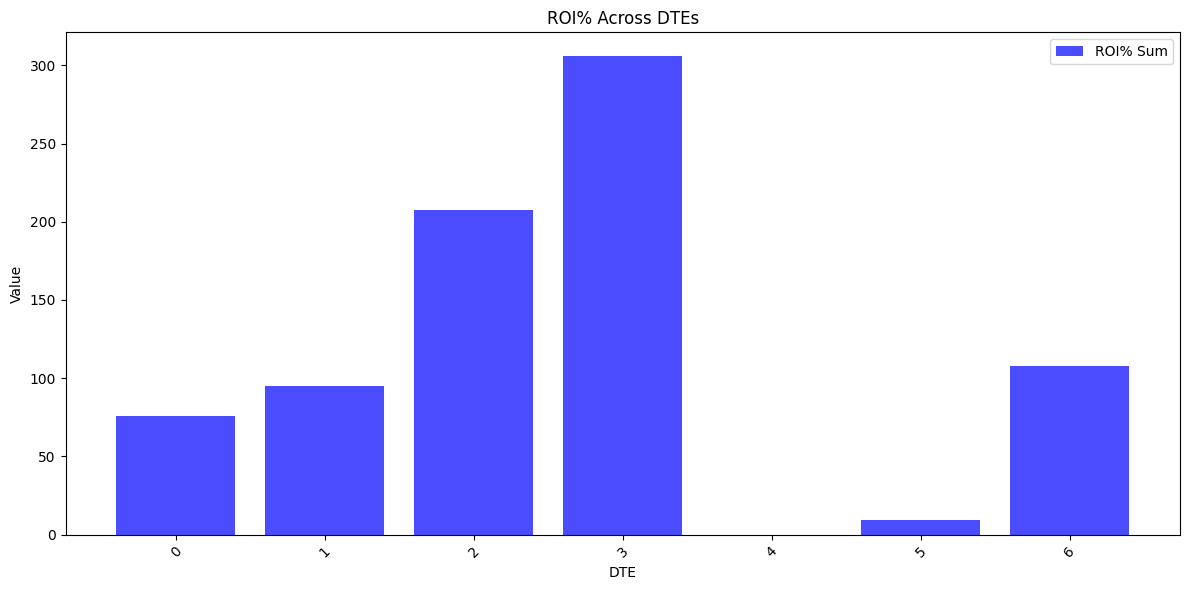

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Check if 'DTE' and 'ROI%' columns exist in the DataFrame
if 'DTE' in tb.columns and 'ROI%' in tb.columns:
    # Group by 'DTE' and calculate the sum of ROI% and max DD
    result = tb.groupby('DTE').agg(
        ROI_Sum=('ROI%', 'sum'),
        Max_DD=('ROI%', lambda x: x.cumsum().min())
    )

    # Plot ROI% Sum and Max DD
    plt.figure(figsize=(12, 6))

    # ROI% Sum plot
    plt.bar(result.index, result['ROI_Sum'], color='blue', alpha=0.7, label='ROI% Sum')

    # Max DD plot
    # plt.plot(result.index, result['Max_DD'], color='red', marker='o', label='Max DD')

    # Graph details
    plt.title("ROI% Across DTEs")
    plt.xlabel("DTE")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Ensure the DataFrame has both 'DTE' and 'ROI%' columns.")
